<a href="https://colab.research.google.com/github/MrKozelberg/qmnn/blob/main/harm_osc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
# PyTorch
import torch
from torch import nn

# Math
import math

# Plots
import matplotlib.pyplot as plt

# Random
import random

# Numpy
import numpy as np

In [2]:
# Detect avaible device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
f0 = lambda x: torch.tanh(x)
f1 = lambda x: 1/torch.cosh(x)**2
f2 = lambda x: -2*torch.sinh(x)/torch.cosh(x)**3

class Perceptron(nn.Module):
  def __init__(self, D: int, M: int, H: list, L: float):
    assert len(H) > 0, "List of hidden layers' widths is empty"
    super(Perceptron, self).__init__()
    self.D = D # Dimension of the initial space
    self.M = M # Dimension of the final space
    self.N = len(H) # Number of the hidden layers
    self.L = L # Box size
    self.stack = nn.Sequential() # Structure of the perceptron
    for n in range(self.N + 1):
      if (n == 0):
        self.stack.append(nn.Linear(D, H[0]))
      elif (n == self.N):
        self.stack.append(nn.Linear(H[-1], M))
      else:
        self.stack.append(nn.Linear(H[n-1], H[n]))
      self.stack.append(nn.Tanh())
    self.stack.to(device)
  
  # Normal distribution
  def weight(self, x: torch.Tensor, mean: float, std: float):
    assert x.shape[1] == self.D, "Wrong shape 1 of the tensor x"
    assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
    return 1 / (std * math.sqrt(2 * math.pi)) \
      * torch.exp(-0.5 * torch.sum((x - mean)**2, axis=1) / std**2)
  
  def stack_gradient(self, x: torch.Tensor):
    assert x.shape[1] == self.D, "Wrong shape 1 of the tensor x"
    assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
    result = torch.zeros((x.shape[0], self.D, self.M)).to(device)
    # Computation of the y
    y = [None] * (self.N + 1)
    y[0] = x
    for i in range(self.N):
      # y(i+1)
      y[i+1] = self.stack[i*2+1](self.stack[i*2](y[i]))
    # Computation of the result
    for d in range(self.D):
      # dy(1)dx
      dydx = f1(self.stack[0](y[0])) * self.stack[0].weight[:,d]
      for i in range(1, self.N + 1):
        # dy(i)dx
        dydx =  f1(self.stack[i*2](y[i])) \
          * torch.matmul(dydx, self.stack[i*2].weight.t())
      # keeping result
      result[:,d,:] = dydx
    return result
  
  def stack_laplacian(self, x: torch.Tensor):
    assert x.shape[1] == self.D, "Wrong shape 1 of the tensor x"
    assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
    preresult = torch.zeros((x.shape[0], self.D, self.M)).to(device)
    # Computation of the y
    y = [None] * (self.N + 1)
    y[0] = x
    for i in range(self.N):
      # y(i+1)
      y[i+1] = self.stack[i*2+1](self.stack[i*2](y[i]))
    # Computation of the result
    for d in range(self.D):
      # dy(1)dx
      dydx = f1(self.stack[0](y[0])) * self.stack[0].weight[:,d]
      # d2y(2)dx2
      d2ydx2 = f2(self.stack[0](y[0])) * self.stack[0].weight[:,d]**2
      for i in range(1, self.N + 1):
        # d2y(i)dx2
        d2ydx2 = f2(self.stack[i*2](y[i])) \
          * torch.matmul(dydx, self.stack[i*2].weight.t())**2 \
          + f1(self.stack[i*2](y[i])) \
          * torch.matmul(d2ydx2, self.stack[i*2].weight.t())
        # dy(i)dx
        dydx =  f1(self.stack[i*2](y[i])) \
          * torch.matmul(dydx, self.stack[i*2].weight.t())
      # keeping preresult
      preresult[:,d,:] = d2ydx2
    return torch.sum(preresult, axis=1) 
  
  def amplitude(self, x: torch.Tensor):
    assert x.shape[1] == self.D, "Wrong shape of the tensor x"
    assert x.shape[0] > 0, "Wrong shape of the tensor x"
    mask = (torch.sum(abs(x)<=self.L, axis=1) == self.D).to(device)
    result = torch.ones((x.shape[0], self.M)).to(device)
    # result = torch.mul(result, 1 / torch.sum(self.stack(x)**2, axis=0))
    result = torch.mul(result.t(),
                       (1 - torch.sum(x**2, axis=1) / self.L**2) * mask).t()
    assert result.shape[1] == self.M, "Wrong shape 1 of the result"
    assert result.shape[0] == x.shape[0], "Wrong shape 0 of the result"
    return result
  
  def amplitude_gradient(self, x: torch.Tensor):
    assert x.shape[1] == self.D, "Wrong shape of the tensor x"
    assert x.shape[0] > 0, "Wrong shape of the tensor x"
    mask = (torch.sum(abs(x)<=self.L, axis=1) == self.D).to(device)
    result = torch.ones((x.shape[0], self.D, self.M)).to(device)
    s = self.stack(x)
    sg = self.stack_gradient(x)
    for d in range(self.D):
      # first term
      a = torch.ones((x.shape[0], self.M)).to(device)
      # a = torch.mul(a, 1 / torch.sum(s**2, axis=0))
      a = torch.mul(a.t(), -2 * x[:,d] / self.L**2 * mask).t()
      # # second term
      # b = torch.ones((x.shape[0], self.M)).to(device)
      # b = torch.mul(b,
      #               -2 / torch.sum(s**2, axis=0)**2 
      #               * torch.sum(s * sg[:,d,:], axis=0))
      # b = torch.mul(b.t(),
      #               (1 - torch.sum(x**2, axis=1) / self.L**2) * mask).t()
      # keeping result
      result[:,d,:] = a #+ b
    return result

  def amplitude_laplacian(self, x: torch.Tensor):
    assert x.shape[1] == self.D, "Wrong shape of the tensor x"
    assert x.shape[0] > 0, "Wrong shape of the tensor x"
    mask = torch.sum(abs(x)<=self.L, axis=1) == self.D
    a = torch.zeros((x.shape[0], self.M)).to(device)
    result = torch.mul(a.t(), -2 * self.D / self.L**2 * mask).t()
    # s = self.stack(x)
    # sg = self.stack_gradient(x)
    # sl = self.stack_laplacian(x)
    # for d in range(self.D):
    #   # zeroth term
    #   z = torch.ones((x.shape[0], self.M)).to(device)
    #   z = torch.mul(z, 1 / torch.sum(s**2, axis=0))
    #   z = torch.mul(z.t(), -2 / self.L**2 * mask).t()
    #   # first term
    #   a = torch.ones((x.shape[0], self.M)).to(device)
    #   a = torch.mul(a, 8 / torch.sum(s**2, axis=0)**2 
    #                 * torch.sum(s * sg[:,d,:], axis=0))
    #   a = torch.mul(a.t(), -2 * x[:,d] / self.L**2 * mask).t()
    #   # second term
    #   b = torch.ones((x.shape[0], self.M)).to(device)
    #   b = torch.mul(b,
    #                 2 / torch.sum(s**2, axis=0)**3 
    #                 * (2 * torch.sum(s * sg[:,d,:], axis=0))**2)
    #   b = torch.mul(b.t(),
    #                 (1 - torch.sum(x**2, axis=1) / self.L**2) * mask).t()
    #   # third term
    #   c = torch.ones((x.shape[0], self.M)).to(device)
    #   c = torch.mul(c,
    #                 -2 / torch.sum(s**2, axis=0)**2 
    #                 * torch.sum(sg[:,d,:]**2, axis=0))
    #   c = torch.mul(c.t(),
    #                 (1 - torch.sum(x**2, axis=1) / self.L**2) * mask).t()
    #   # keeping result
    #   result += z + a + b + c
    # # last term
    # d = torch.ones((x.shape[0], self.M)).to(device)
    # d = torch.mul(d,
    #               -2 / torch.sum(s**2, axis=0)**2 
    #               * torch.sum(s * sl, axis=0))
    # d = torch.mul(d.t(),
    #               (1 - torch.sum(x**2, axis=1) / self.L**2) * mask).t()
    # result += d
    return result
    
  def forward(self, x: torch.Tensor):
    assert x.shape[1] == self.D, "Wrong shape 1 of the tensor x"
    assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
    result = self.stack(x).to(device) * self.amplitude(x).to(device) # Multiply by amplitude
    assert result.shape[1] == self.M, "Wrong shape 1 of the result"
    assert result.shape[0] == x.shape[0], "Wrong shape 0 of the result"
    return result
  
  def gradient(self, x: torch.Tensor):
    assert x.shape[1] == self.D, "Wrong shape of the tensor x"
    assert x.shape[0] > 0, "Wrong shape of the tensor x"
    result = torch.zeros((x.shape[0], self.D, self.M)).to(device)
    a = self.amplitude(x)
    sg = self.stack_gradient(x)
    s = self.stack(x)
    ag = self.amplitude_gradient(x)
    for d in range(self.D):
      result[:,d,:] = sg[:,d,:] * a + s * ag[:,d,:]
    return result

  def laplacian(self, x: torch.Tensor):
    assert x.shape[1] == self.D, "Wrong shape of the tensor x"
    assert x.shape[0] > 0, "Wrong shape of the tensor x"
    result = self.stack_laplacian(x) * self.amplitude(x) \
      + self.stack(x) * self.amplitude_laplacian(x) \
      + 2 * torch.sum(self.stack_gradient(x) * self.amplitude_gradient(x), 
                      axis=1)
    return result
  
  def wavefunction_norm2(self, x: torch.Tensor, mean: float, std: float):
    assert x.shape[1] == self.D, "Wrong shape 1 of the tensor x"
    assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
    result = torch.zeros(self.M).to(device)
    f = self.forward(x)
    w = self.weight(x, mean, std)
    for m in range(self.M):
      result[m] = torch.mean(abs(f[:,m])**2 / w)
    return result
  
  def mean_hamiltonian(self, x: torch.Tensor, mean: float, std: float):
    assert x.shape[1] == self.D, "Wrong shape 1 of the tensor x"
    assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
    result = torch.zeros(self.M).to(device)
    f = self.forward(x)
    l = self.laplacian(x)
    w = self.weight(x, mean, std)
    v = 0.5 * torch.sum(x**2, axis=1)
    for m in range(self.M):
      result[m] = torch.mean(f[:,m] * (-0.5 * l[:,m] + v * f[:,m]) / w)
    return result
  
  def energies(self, x: torch.Tensor, mean: float, std: float):
    assert x.shape[1] == self.D, "Wrong shape 1 of the tensor x"
    assert x.shape[0] > 0, "Wrong shape 0 of the tensor x"
    return self.mean_hamiltonian(x, mean, std) \
      / self.wavefunction_norm2(x, mean, std)

  def train_step(self, optimizer, scheduler, loss_function, B: int, mean: float,
                 std: float, alpha: float, beta: float):
    # Normal distributed x
    x = torch.normal(mean=mean, std=std, size=(B, self.D)).to(device)
    e = self.energies(x, mean, std)
    f = self.forward(x)
    w = self.weight(x, mean, std)
    # Residual
    residual = -0.5 * self.laplacian(x) \
      + 0.5 * torch.mul(f.t(), torch.sum(x**2, axis=1)).t() \
      - torch.mul(f, e)
    # Orthonormalization
    norm2 = self.wavefunction_norm2(x, mean, std)
    a = torch.mean((norm2 - torch.tensor(1).to(device))**2)
    b = torch.zeros(self.M, self.M).to(device).to(device)
    for m1 in range(1, self.M):
      for m2 in range(0, m1):
        b[m1,m2] = torch.mean(f[:,m1] * f[:,m2] / w)**2
    # Loss
    tau = 1.
    loss = loss_function(torch.sum(torch.mean(residual**2, axis=0))
      + alpha * a 
      + beta * torch.sum(b),
      torch.tensor(0.0).to(device))
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item(), self.energies(x, mean, std).tolist()
  
  def train_loop(self, I: int, lr0: float, weight_decay: float, gamma: float):
    optimizer = torch.optim.Adam(params=list(self.parameters()), 
                                 lr=lr0, 
                                 weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 
                                                       gamma=gamma)
    # Orthonormalization weights
    alpha = 1.
    beta = 100.
    # Batch size
    B = 2000 #int(10**(self.D + 2))
    e_list = [None] * I
    l_list = [None] * I
    # Main loop
    print('i,\t Loss,\t Energies')
    for i in range(I):
      l_list[i], e_list[i] = self.train_step(optimizer, scheduler, nn.MSELoss(),
                                             B, 0., self.L/2, alpha, beta)
      if i % 1000 == 0:
        print(f"{i:3d}\t {l_list[i]:.4E}\t {e_list[i]}")
    return l_list, e_list

In [6]:
D = 2
M = 16
H = [100,100,100]
L = 5.
perceptron = Perceptron(D, M, H, L).to(device)
I = 25000
lr0 = 1e-3
weight_decay = 1e-3
gamma = 0.1**(1/I)
l_list, e_list = perceptron.train_loop(I, lr0=lr0, 
                                       weight_decay=weight_decay,
                                       gamma=gamma)


i,	 Loss,	 Energies
  0	 1.0159E+03	 [4.041000843048096, 4.837772846221924, 6.831523895263672, 5.667828559875488, 5.8808913230896, 4.64492130279541, 4.652353286743164, 9.078237533569336, 5.669465065002441, 3.983855962753296, 6.078038692474365, 5.97326135635376, 3.427149772644043, 7.334981441497803, 6.794328212738037, 5.600841999053955]
1000	 1.0165E+00	 [8.321622848510742, 7.887172222137451, 5.454674243927002, 1.622173547744751, 3.3542978763580322, 4.246764659881592, 6.014481544494629, 4.990777015686035, 6.943624973297119, 4.12930965423584, 7.380996227264404, 6.152428150177002, 4.618420124053955, 7.718743801116943, 7.600441932678223, 6.774890899658203]
2000	 1.0052E+00	 [7.651739120483398, 7.691958427429199, 5.590188026428223, 1.354618787765503, 3.123049736022949, 5.726171016693115, 5.5236101150512695, 4.295077323913574, 7.4486308097839355, 3.244272470474243, 7.111454010009766, 6.76012659072876, 4.065120697021484, 7.627101898193359, 8.451285362243652, 6.50269889831543]
3000	 1.0019E+00

Text(0.5, 0, 'Iteration number')

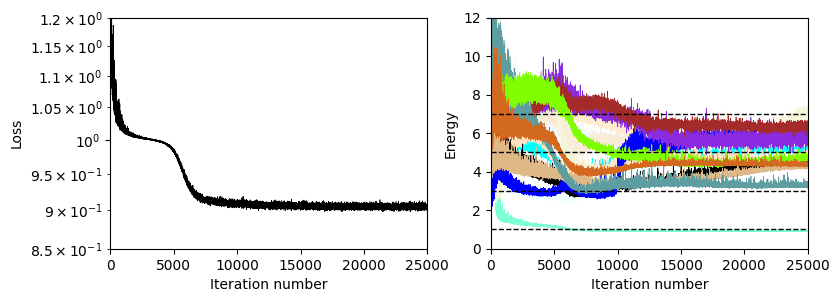

In [50]:
fig, ax = plt.subplots(1,2,figsize=(9,3))

all_colors = list(plt.cm.colors.cnames.keys()) 

ax[0].plot(l_list, linewidth=0.5, color='black')
ax[0].set_yscale('log')
ax[0].set_xlim(0,I)
# ax[0].grid(axis='y')
ax[0].set_ylabel('Loss')
ax[0].set_ylim(8.5e-1,1.2)
ax[0].set_xlabel('Iteration number')

for m in range(perceptron.M):
  ax[1].plot(np.array(e_list)[:,m], color=all_colors[m], linewidth=0.5)

for m in range(M//4):
  ax[1].axhline(y=D*(1/2 + m), color='black', linestyle='--', linewidth=1)

ax[1].set_xlim(0,I)
ax[1].set_ylim(0,12)
# ax[1].grid()
ax[1].set_ylabel('Energy')
ax[1].set_xlabel('Iteration number')
# ax[1].set_yscale('log')


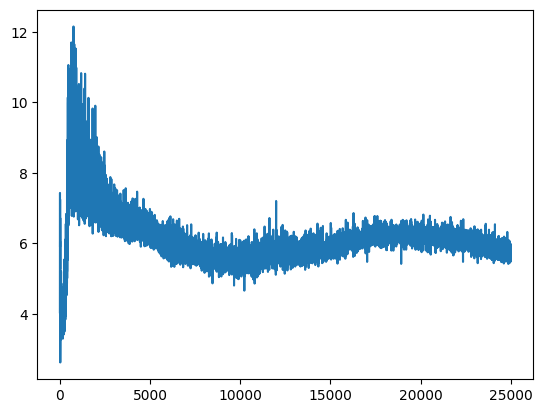

In [40]:
plt.plot(np.array(e_list)[:,0])

In [33]:
c[0]

'grey'

In [ ]:
fv
ddc

In [ ]:
# test costructor, forward and amplitude, stack_gradient, stack_laplacian
D = 3
M = 5
H = [D, 2*D, 3*D]
L = 5.
perceptron = Perceptron(D, M, H, L).to(device)
B = 10000
x = torch.normal(mean=0., std=L/2, size=(B, D)).to(device)
print(x.device)
sg = perceptron.stack_gradient(x)
print(sg.device)
sl = perceptron.stack_laplacian(x)
print(sl.device)
a = perceptron.amplitude(x)
print(a.device)
ag = perceptron.amplitude_gradient(x)
print(ag.device)
al = perceptron.amplitude_laplacian(x)
print(al.device)
y = perceptron(x)
print(y.device)
g = perceptron.gradient(x)
print(g.device)
l = perceptron.laplacian(x)
print(l.device)
print(perceptron.energies(x, 0., L/2).device)

cuda:0
cuda:0
cuda:0
cuda:0


RuntimeError: ignored

In [ ]:
optimizer = torch.optim.Adam(params=list(perceptron.parameters()), lr=1e-3, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)

perceptron.train_step(optimizer, scheduler, nn.MSELoss(), 100, 0, L/2, 1, 1)

(0.6759825348854065,
 [7.858370304107666,
  7.779535293579102,
  6.816428184509277,
  12.6932954788208,
  8.333465576171875])

In [ ]:
d = 2
y = x
dydx = 1 / torch.cosh(perceptron.stack[0](y)) * perceptron.stack[0].weight[:,d]
y = perceptron.stack[1](perceptron.stack[0](y))
dydx =  1 / torch.cosh(perceptron.stack[2](y)) * torch.matmul(dydx, perceptron.stack[2].weight.t())

In [ ]:
a = torch.rand(10,6)
b = torch.rand(7,6)
ab = torch.matmul(a, b.t())
ab.shape

torch.Size([10, 7])

In [ ]:
perceptron.stack[7]

Tanh()

In [ ]:
torch.mul(torch.rand(10,6).t(), torch.rand(7,6))

RuntimeError: ignored

In [ ]:
dydx.shape, perceptron.stack[2].weight.shape

(torch.Size([10, 6]), torch.Size([7, 6]))

In [ ]:
(1 / torch.cosh(perceptron.stack[2](y))).shape, torch.sum(dydx * perceptron.stack[2].weight.t(), axis=1).shape

RuntimeError: ignored

In [ ]:
(1 / torch.cosh(perceptron.stack[0](y))).shape

torch.Size([10, 10])

(torch.Size([10, 5]), torch.Size([10]))

torch.Size([10, 5])

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Mar  4 14:35:53 2023

@author: kozlov
"""

import numpy as np  # to work with arrays
import matplotlib.pyplot as plt  # to make figures

# PyTorch
import torch
from torch import nn


def f0(x):
    return torch.tanh(x)


def f1(x):
    return 1/torch.cosh(x)**2


def f2(x):
    return -2*torch.sinh(x)/torch.cosh(x)**3


class tPerceptron(nn.Module):
    def __init__(self, L, N_h, D, N, std):
        self.D = D  # dimension of the task
        self.N = N  # number of the most excided state
        self.L = L  # depth
        self.N_h = N_h  # width
        self.f = f0  # activation function
        self.f1 = f1  # first derivative
        self.f2 = f2  # second derivative

        super(tPerceptron, self).__init__()

        self.std = std #nn.Parameter(data=torch.Tensor([std]), requires_grad=True)

        self.stack = nn.Sequential()
        for i in range(self.L + 1):
            if (i == 0):
                self.stack.append(nn.Linear(D, N_h))
            elif (i == self.L):
                self.stack.append(nn.Linear(N_h, N + 1))
            else:
                self.stack.append(nn.Linear(N_h, N_h))
            self.stack.append(nn.Tanh())

        self.h = [None] * (self.L + 1)  # outputs of the layers

    def forward(self, x):
        S = x.shape[0]  # Size of the sample
        assert x.shape[1] == self.D, 'Wrong shape of the matrix X'

        for i in range(self.L + 1):
            if i == 0:
                self.h[i] = self.stack[2*i+1](
                    self.stack[2*i](x))
            else:
                self.h[i] = self.stack[2*i+1](
                    self.stack[2*i](self.h[i-1]))

        assert self.h[self.L].shape[0] == S, 'Wrong shape of the h[-1]'
        assert self.h[self.L].shape[1] == \
            self.N + 1, 'Wrong shape of the h[-1]'

        # Normalization each wavefunction
        res = torch.ones_like(self.h[-1])
        for i in range(self.N + 1):
            res[:, i] = self.h[-1][:, i] \
                * torch.exp(-torch.sum(x**2 / self.std**2, axis=1))

        return res

    def grad(self, x):
        S = x.shape[0]  # Size of the sample
        assert x.shape[1] == self.D, 'Wrong shape of the matrix X'

        _ = self.forward(x)  # computes outputs of the layers

        res = torch.zeros(S, self.N + 1, self.D)  # result

        for t in range(self.D):
            dh_dx = torch.zeros(self.D)
            dh_dx[t] = 1

            for i in range(self.L + 1):
                a = self.stack[2*i].weight
                b = self.stack[2*i].bias
                if i == 0:
                    dh_dx = self.f1(x @ a.t() + b) \
                        * (dh_dx @ a.t())
                else:
                    dh_dx = self.f1(self.h[i-1] @ a.t() + b) \
                        * (dh_dx @ a.t())

            assert dh_dx.shape[0] == S
            assert dh_dx.shape[1] == self.N + 1

            for i in range(self.N + 1):
                dh_dx[:, i] = dh_dx[:, i] \
                    * torch.exp(-torch.sum(x**2 / self.std**2, axis=1))

            for i in range(self.N + 1):
                dh_dx[:, i] = dh_dx[:, i] + self.h[-1][:, i] \
                    * torch.exp(-torch.sum(x**2 / self.std**2, axis=1)) \
                    * (-2 * x[:, t] / self.std**2)

            res[:, :, t] = dh_dx

        return res  # / torch.linalg.vector_norm(self.h[-1], axis=0)

    def lap(self, x):
        S = x.shape[0]  # Size of the sample
        assert x.shape[1] == self.D, 'Wrong shape of the matrix X'

        _ = self.forward(x)  # computes outputs of the layers
        
        res = torch.zeros(S, self.N + 1)
        
        for t in range(self.D):
            dh_dx = torch.zeros(self.D) #
            dh_dx[t] = 1 # 
            
            d2h_dx2 =  torch.zeros(self.D) #
            
            for i in range(self.L + 1):
                a = self.stack[2*i].weight
                b = self.stack[2*i].bias
                
                if i == 0:
                    d2h_dx2 = self.f2(x @ a.t() + b) * (dh_dx @ a.t())**2
                else:
                    d2h_dx2 = self.f2(self.h[i-1] @ a.t() + b) \
                        * (dh_dx @ a.t())**2\
                    + self.f1(self.h[i-1] @ a.t() + b) * (d2h_dx2 @ a.t())

                if i == 0:
                    dh_dx = self.f1(x @ a.t() + b) \
                        * (dh_dx @ a.t())
                else:
                    dh_dx = self.f1(self.h[i-1] @ a.t() + b) \
                        * (dh_dx @ a.t())
                
            assert dh_dx.shape[0] == S
            assert dh_dx.shape[1] == self.N + 1
                
            assert d2h_dx2.shape[0] == S
            assert d2h_dx2.shape[1] == self.N + 1
            
            for j in range(self.N + 1):
                d2h_dx2[:, j] = d2h_dx2[:, j] \
                    * torch.exp(-torch.sum(x**2 / self.std**2, axis=1)) \
                    + 2 * dh_dx[:, j] \
                        * torch.exp(-torch.sum(x**2 / self.std**2, axis=1)) \
                        * (- 2 * x[:, t] / self.std**2) \
                    + self.h[-1][:, j] \
                        * torch.exp(-torch.sum(x**2 / self.std**2, axis=1)) \
                        * (-2 / self.std**2)

            res = res + d2h_dx2

        return res

    def energy(self, x, V, W):
        S = x.shape[0]  # Size of the sample
        assert x.shape[1] == self.D, 'Wrong shape of the matrix X'

        assert V(x).shape[0] == S

        res = torch.empty(self.N + 1)

        psi = self.forward(x)
        lap_psi = self.lap(x)

        for i in range(self.N + 1):
            res[i] = torch.mean((- 1 / 2 * psi[:, i] * lap_psi[:, i]
                                + psi[:, i]**2 * V(x)) / W(x)) \
                / torch.mean(psi[:, i]**2 / W(x))

        return res


def train_step(perceptron, optimizer, scheduler, loss_fn, S, mean, std,
               alpha, beta):
    # Create an uninitialized tensor of size SxD
    x = torch.empty(S, perceptron.D)

    # Normal distributed x
    x.normal_(mean, std)

    # Potential
    V = lambda y: torch.linalg.vector_norm(y, axis=1)**2 / 2

    # Weight function
    W = lambda y: 1 / (std * np.sqrt(2 * np.pi)) \
        * torch.exp(-1/2*torch.mean((y - mean)**2 / std**2, axis=1))

    # Residual
    residual = torch.empty(perceptron.N + 1)
    e = perceptron.energy(x, V, W)
    psi = perceptron.forward(x)
    lap_psi = perceptron.lap(x)
    for i in range(perceptron.N + 1):
        residual[i] = (i+1) * (torch.mean((- 1 / 2 * psi[:, i] * lap_psi[:, i]
                                            + psi[:, i]**2 * V(x)) / W(x))) / torch.mean(psi[:, i]**2 / W(x))
                                            # - e[i] * psi[:, i]**2) / W(x))) \
            # / torch.mean(psi[:, i]**2 / W(x))

    # Orthonormalization
    a = torch.empty(perceptron.N + 1)
    for i in range(perceptron.N + 1):
        a[i] = (torch.mean(psi[:, i]**2 / W(x)) - torch.tensor([1.0]))**2

    b = torch.zeros(perceptron.N + 1, perceptron.N + 1)
    for n in range(1, perceptron.N + 1):
        for m in range(0, n):
            b[n, m] = torch.mean(psi[:, n] * psi[:, m] / W(x))**2

    # Loss function
    loss = loss_fn(torch.mean(residual)
                   + alpha * torch.sum(a)
                   + beta * torch.sum(b), torch.tensor(0.0))

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    return loss.item(), perceptron.energy(x, V, W).tolist()


def train_loop(perceptron, N_iter):
    losses = np.zeros(N_iter)
    es = np.zeros((N_iter, perceptron.N + 1))

    # Training parameters
    Ss = 2000  # np.logspace(3, 4, N_iter, dtype=int)

    params = list(perceptron.parameters())
    # params.extend(perceptron.std)
    optimizer = torch.optim.Adam(params=params, lr=1e-3, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)
    loss_fn = nn.MSELoss()

    print("Step number, Loss, Energies")

    for i in range(N_iter):
        losses[i], es[i] = train_step(perceptron, optimizer, scheduler,
                                      loss_fn, Ss, 0.0, 2.25, 1.0, 1.0)

        if i % 500 == 0:
            print(f"{i}\t{losses[i]:6.4g}\t{es[i]}")

    return losses, es

In [ ]:
type(torch.optim.Adam(params=list(perceptron.parameters()), lr=1e-3, weight_decay=1e-3))

torch.optim.adam.Adam

In [ ]:
torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)

NameError: ignored

In [ ]:
perceptron = tPerceptron(L=4, N_h=36, D=2, N=0, std=2.25)

In [ ]:
losses, es = train_loop(perceptron, 20000)

Step number, Loss, Energies
0	 9.366	[1.66063821]
500	 1.467	[1.17119062]
1000	  1.36	[1.12825847]
1500	 1.314	[1.12878895]
2000	 1.473	[1.16766167]
2500	 1.285	[1.11709142]
3000	 1.378	[1.13629901]
3500	 1.372	[1.14500237]
4000	 1.435	[1.14711392]
4500	 1.351	[1.12970877]
5000	 1.329	[1.13227189]
5500	 1.308	[1.10609925]
6000	 1.271	[1.09210813]
6500	 1.383	[1.14872801]
7000	 1.338	[1.1239351]
7500	 1.405	[1.14880371]
8000	 1.424	[1.14317727]
8500	 1.361	[1.1409241]
9000	 1.312	[1.11699069]
9500	 1.327	[1.1315192]
10000	 1.305	[1.11485398]
10500	 1.443	[1.15054905]
11000	 1.369	[1.14190197]
11500	 1.349	[1.11420012]
12000	 1.294	[1.10191929]
12500	  1.25	[1.10546458]
13000	 1.443	[1.137676]
13500	 1.345	[1.13484037]
14000	 1.351	[1.13961744]
14500	 1.347	[1.13031936]
15000	 1.332	[1.11831915]
15500	 1.324	[1.11711872]
16000	 1.321	[1.12288201]
16500	 1.333	[1.13459361]
17000	 1.386	[1.13653111]
17500	 1.244	[1.08579314]
18000	 1.265	[1.10146987]
18500	 1.334	[1.13191295]
19000	 1.358	

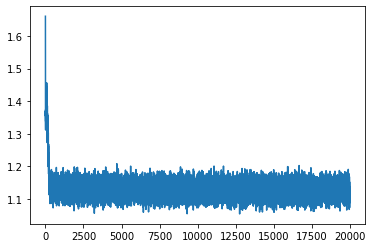

In [ ]:
plt.plot(es[:,0])
# plt.yscale('log')

In [ ]:
def modified_train_loop(perceptrons, N_iter, delta, mean, std, alpha, beta):
    losses = np.zeros((N_iter, len(perceptrons)))
    es = np.zeros((N_iter, len(perceptrons)))

    # Training parameters
    Ss = np.logspace(3, 4, N_iter // delta, dtype=int)
    optimizers = [torch.optim.Adam(params=perceptrons[i].parameters(), lr=1e-4) 
      for i in range(len(perceptrons))]
    schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizers[i], gamma=0.999) 
      for i in range(len(perceptrons))]
    loss_fn = nn.MSELoss()

    print("Step number, Loss, Energies")

    # Potential
    V = lambda y: torch.linalg.vector_norm(y, axis=1)**2 / 2

    # Weight function
    W = lambda y: 1 / (std * np.sqrt(2 * np.pi)) \
        * torch.exp(-1/2*torch.mean((y - mean)**2 / std**2, axis=1))

    for i in range(N_iter):
      j = i // delta % len(perceptrons)

      # Create an uninitialized tensor of size SxD
      x = torch.empty(Ss[i // delta], perceptrons[j].D)

      # Normal distributed x
      x.normal_(mean, std)

      e = torch.empty(len(perceptrons))
      psi = torch.empty(Ss[i // delta], len(perceptrons))
      lap_psi = torch.empty(Ss[i // delta], len(perceptrons))
      a = torch.zeros(len(perceptrons))
      b = torch.zeros(len(perceptrons), len(perceptrons))
      for n in range(len(perceptrons)):
          psi[:, n] = perceptrons[n](x).reshape(-1)
          lap_psi[:, n] = perceptrons[n].lap(x).reshape(-1)
          
      for n in range(len(perceptrons)):
          e[n] = torch.abs(torch.mean((- 1 / 2 * psi[:, n] * lap_psi[:, n]
                                            + psi[:, n]**2 * V(x)) / W(x))) \
                                            / torch.mean(psi[:, n]**2 / W(x))
          a[n] = (torch.mean(psi[:, n]**2 / W(x)) - torch.tensor(1.0))**2
          if n > 0:
              for m in range(0, n):
                  b[n, m] = torch.mean(psi[:, n] * psi[:, m] / W(x))**2
      # Loss function
      loss = loss_fn(torch.mean(e)
                   + alpha * torch.sum(a)
                   + beta * torch.sum(b), torch.tensor(0.0))
      
      # Backpropagation
      optimizers[j].zero_grad()
      loss.backward()
      optimizers[j].step()
      schedulers[j].step()

      if i % delta == 0:
          print(f"{i}\t{losses[i,:]}\t{es[i,:]}")

    return losses, es

In [ ]:
perceptrons = [tPerceptron(L=2, N_h=10, D=2, N=0, std=2.25), 
               tPerceptron(L=3, N_h=15, D=2, N=0, std=2.25),
               tPerceptron(L=3, N_h=20, D=2, N=0, std=2.25),
               tPerceptron(L=3, N_h=25, D=2, N=0, std=2.25)]

In [ ]:
losses, es = modified_train_loop(perceptrons, 30000, 100, 0.0, 2.25, 1.0, 0.1)

Step number, Loss, Energies
0	[0. 0. 0. 0.]	[0. 0. 0. 0.]
100	[0. 0. 0. 0.]	[0. 0. 0. 0.]
200	[0. 0. 0. 0.]	[0. 0. 0. 0.]
300	[0. 0. 0. 0.]	[0. 0. 0. 0.]
400	[0. 0. 0. 0.]	[0. 0. 0. 0.]
500	[0. 0. 0. 0.]	[0. 0. 0. 0.]
600	[0. 0. 0. 0.]	[0. 0. 0. 0.]
700	[0. 0. 0. 0.]	[0. 0. 0. 0.]
800	[0. 0. 0. 0.]	[0. 0. 0. 0.]
900	[0. 0. 0. 0.]	[0. 0. 0. 0.]
1000	[0. 0. 0. 0.]	[0. 0. 0. 0.]
1100	[0. 0. 0. 0.]	[0. 0. 0. 0.]


KeyboardInterrupt: ignored

In [ ]:
plt.plot(losses)
plt.yscale('log')
plt.xlim(0,20000)

In [ ]:
del perceptron
torch.cuda.empty_cache()

In [ ]:
device

device(type='cuda')